In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [247]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 15, 
                                  use_potential = False,
                                  decay = 40,
                                  thresh = 1e-4)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_r1b2_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 15, 
                                  use_potential = False,
                                  decay = 40,
                                  thresh = 1e-4)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)


In [248]:
def train_unpaired(model_rna, model_atac, disc, data_loader_rna, data_loader_atac, diff_sim_rna, 
                   diff_sim_atac, optimizer_rna, optimizer_atac, optimizer_D, U_rna = None, U_atac = None, n_epochs = 50, 
                   n_iter = 15, lamb_r_rna = 1, lamb_r_atac = 1, lamb_disc = 1, dist_mode = "inner_product"):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for epoch in range(n_epochs):
        iteration = zip(data_loader_rna, data_loader_atac)
        for data in iteration:
            # Update RNA Encoder
            data_rna, data_atac = data
            batch_cols_rna = data_rna['index'].to(device)
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count'].to(device)

            batch_expr_r_rna = model_rna(batch_expr_rna)
            z_rna = model_rna[:1](batch_expr_rna)
            
            # batch U_t
            batch_U_rna = U_rna[batch_cols_rna, :][:, batch_cols_rna]


            train_loss_rna, loss_recon_rna, loss_dist_rna = traj_loss(recon_x = batch_expr_r_rna, x = batch_expr_rna, z = z_rna, 
            diff_sim = batch_sim_rna, U_t = batch_U_rna, lamb_recon = lamb_r_rna, lamb_dist = 1, recon_mode = "relative", dist_mode = dist_mode)

            train_loss_rna.backward()
            optimizer_rna.step()
            optimizer_rna.zero_grad()

            # Update ATAC Encoder
            batch_cols_atac = data_atac['index'].to(device)
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count'].to(device)

            batch_expr_r_atac = model_atac(batch_expr_atac)
            z_atac = model_atac[:1](batch_expr_atac)

            # batch U_t
            batch_U_atac = U_atac[batch_cols_atac, :][:, batch_cols_atac]


            train_loss_atac, loss_recon_atac, loss_dist_atac = traj_loss(recon_x = batch_expr_r_atac, x = batch_expr_atac, z = z_atac, 
            diff_sim = batch_sim_atac, U_t = batch_U_atac, lamb_recon = lamb_r_atac, lamb_dist = 1, recon_mode = "relative", dist_mode = dist_mode)

            train_loss_atac.backward()
            optimizer_atac.step()
            optimizer_atac.zero_grad()

            # need to go through all the calculation again since the encoder has been updated, ERROR shows up in pytorch 1.5 and above.
            # see: https://github.com/pytorch/pytorch/issues/39141 
            z_rna = model_rna[:1](batch_expr_rna)
            z_atac = model_atac[:1](batch_expr_atac)

            # Update Discriminator
            D_loss_avg = 0
            n_rna = batch_cols_rna.shape[0]
            n_atac = batch_cols_atac.shape[0]
            # note that detach here is necessary, use directly will cause error in encoder update later
            input_disc = torch.cat((z_rna.detach(), z_atac.detach()), dim = 0)
            target = torch.cat((torch.full((n_rna, ), 0, dtype = torch.float), torch.full((n_atac, ), 1, dtype = torch.float))).to(device)
            

            for i in range(n_iter):
                output = disc(input_disc).squeeze()
                D_loss = lamb_disc * F.binary_cross_entropy(output, target)
                D_loss_avg += D_loss.item()
                D_loss.backward()
                optimizer_D.step()
                optimizer_D.zero_grad()
            D_loss_avg /= n_iter

            # Update Encoder
            E_loss = -lamb_disc * F.binary_cross_entropy(disc(torch.cat((z_rna, z_atac), dim = 0)).squeeze(), target)
            E_loss.backward()
            optimizer_rna.step()
            optimizer_atac.step()
            optimizer_rna.zero_grad()
            optimizer_atac.zero_grad()

        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item())
            log_D = "Discriminator loss: {:.5f}".format(D_loss_avg)
            print("epoch: ", epoch, log_rna, log_atac, log_D)



In [249]:
def kernel(dist, knn = 5, bandwidth_scale = 1, decay = 5, thresh = 0):
    """
    Kernelize the distance matrix

    Parameters
    -------
    dist: Pair-wise distance matrix

    Returns
    -------
    K : kernel matrix, shape=[n_samples, n_samples]
        symmetric matrix with ones down the diagonal
        with no non-negative entries.

    Raises
    ------
    ValueError: if `precomputed` is not an acceptable value
    """

    # np.partition, first sort the value of each row(small to large), pick the knn+1th element, and put it in the knn+1th place, 
    # and the elements smaller than the value are put in the front, rest are put in the later (without changing order)

    # here basically find the knnth neighbor
    knn_dist = np.partition(dist.detach().numpy(), knn + 1, axis=1)[:, :knn + 1]
    # find the largest one
    bandwidth = np.max(knn_dist, axis=1)
    bandwidth = torch.FloatTensor(bandwidth * bandwidth_scale)
    # divide by the knnth neighbor
    dist = (dist.T / bandwidth).T
    K = torch.exp(-1 * dist ** decay)

    # handle nan, cannot back propagate
    # K[K!=K] = 1.0
    # K[K < thresh] = 0
    K = (K + K.T) / 2
    return K



def traj_loss(recon_x, x, z, diff_sim, U_t = None, lamb_recon = 1, lamb_dist = 1, recon_mode = "original", dist_mode = "inner_product"):
    """\
    Description:
    ------------
        Loss for latent space learning that preserve the trajectory structure. Include reconstruction(relative) loss and distance preservation loss.
    
    Parameters:
    ------------
    recon_x:
        Reconstructed feature matrix, of the size (batch_size, n_features)
    x:
        Original input, of the size (batch_size, n_features)
    z:
        Learned latent space, of the size (batch_size, 2)
    diff_sim:
        Diffusion distance calculated on original dataset, ground truth, of the size (batch_size, batch_size)
    lamb_recon:
        Regularization coefficient for reconstruction loss
    lamb_dis
        Regularization coefficient for distance preservation loss
    recon_mode:
        Reconstruction mode, of two mode, "original" calculuates the original mse loss, "relative" calculates the mse loss of normalized data.  
    
    Returns:
    ------------
    loss:
        Total loss
    loss_recon:
        Reconstruction loss
    loss_dist:
        Distance preservation loss
    """

    if recon_mode == "original":
        loss_recon = lamb_recon * F.mse_loss(recon_x, x)
    elif recon_mode == "relative":
        mean_recon = torch.mean(recon_x, dim = 0)
        var_recon = torch.var(recon_x, dim = 0)
        mean_x = torch.mean(x, dim = 0)
        var_x = torch.var(x, dim = 0)
        # relative loss
        loss_recon = lamb_recon * F.mse_loss(torch.div(torch.add(x, -1.0 * mean_x), (torch.sqrt(var_x + 1e-12)+1e-12)), torch.div(torch.add(x, -1.0 * mean_recon), (torch.sqrt(var_recon + 1e-12)+1e-12)))
    else:
        raise ValueError("recon_mode can only be original or relative")

    # cosine similarity loss
    latent_sim = pairwise_distance(z)

    if dist_mode == "inner_product":
        # normalize latent similarity matrix
        latent_sim = latent_sim / torch.norm(latent_sim, p='fro')
        diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')
        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist = - lamb_dist * torch.sum(diff_sim * latent_sim) 

    elif dist_mode == "mse":
        # MSE loss
        # normalize latent similarity matrix
        latent_sim = latent_sim / torch.norm(latent_sim, p='fro')
        diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')
        loss_dist = lamb_dist * torch.norm(diff_sim - latent_sim, p = 'fro')
    elif dist_mode == "kl":
        if U_t is None:
            raise ValueError("`U_t` cannot be `None`")
        K = kernel(latent_sim)
        assert torch.sum(torch.isnan(K)) == 0
        # normalize into transition probability
        P = K / torch.sum(K, dim = 1)[:,None] + 1e-7
        assert torch.sum(torch.isnan(P)) == 0
        # n_sample by n_dimension, diffusion distribution from original space
        U_t = U_t / torch.sum(U_t, dim = 1)[:,None] + 1e-7
        assert torch.sum(torch.isnan(U_t)) == 0
        # average JSD
        M = 0.5 * (U_t + P)
        assert torch.sum(torch.isnan(M)) == 0

        # nan in log, 0 in K
        kl = 0.5 * torch.sum(P * torch.log(P / M)) + 0.5 *  torch.sum(U_t * torch.log(U_t / M))
        loss_dist = lamb_dist * kl
    else:
        raise ValueError("`dist_model` should only be `mse` or `inner_product`")

    loss = loss_recon + loss_dist
    return loss, loss_recon, loss_dist

In [250]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 5e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 5e-4)

In [251]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, U_rna= U_t1, U_atac= U_t2, n_epochs=101, n_iter=15, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=0, dist_mode = "kl")

epoch:  0 RNA loss: 106.06339, RNA recon loss: 0.00000, RNA dist loss: 106.06339 ATAC loss: 95.19800, ATAC recon loss: 0.00000, ATAC dist loss: 95.19800 Discriminator loss: 0.00000
epoch:  10 RNA loss: 25.31866, RNA recon loss: 0.00000, RNA dist loss: 25.31866 ATAC loss: 20.23003, ATAC recon loss: 0.00000, ATAC dist loss: 20.23003 Discriminator loss: 0.00000
epoch:  20 RNA loss: 18.47849, RNA recon loss: 0.00000, RNA dist loss: 18.47849 ATAC loss: 15.69131, ATAC recon loss: 0.00000, ATAC dist loss: 15.69131 Discriminator loss: 0.00000
epoch:  30 RNA loss: 16.20183, RNA recon loss: 0.00000, RNA dist loss: 16.20183 ATAC loss: 13.97024, ATAC recon loss: 0.00000, ATAC dist loss: 13.97024 Discriminator loss: 0.00000
epoch:  40 RNA loss: 16.71212, RNA recon loss: 0.00000, RNA dist loss: 16.71212 ATAC loss: 16.49791, ATAC recon loss: 0.00000, ATAC dist loss: 16.49791 Discriminator loss: 0.00000
epoch:  50 RNA loss: 21.91652, RNA recon loss: 0.00000, RNA dist loss: 21.91652 ATAC loss: 13.87376

In [23]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config': symsim_CONFIG
# }, './saved_model/symsim_phate.pt')

In [25]:
# state = torch.load('./saved_model/symsim_phate.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)
# disc.load_state_dict(state['disc'])

<All keys matched successfully>

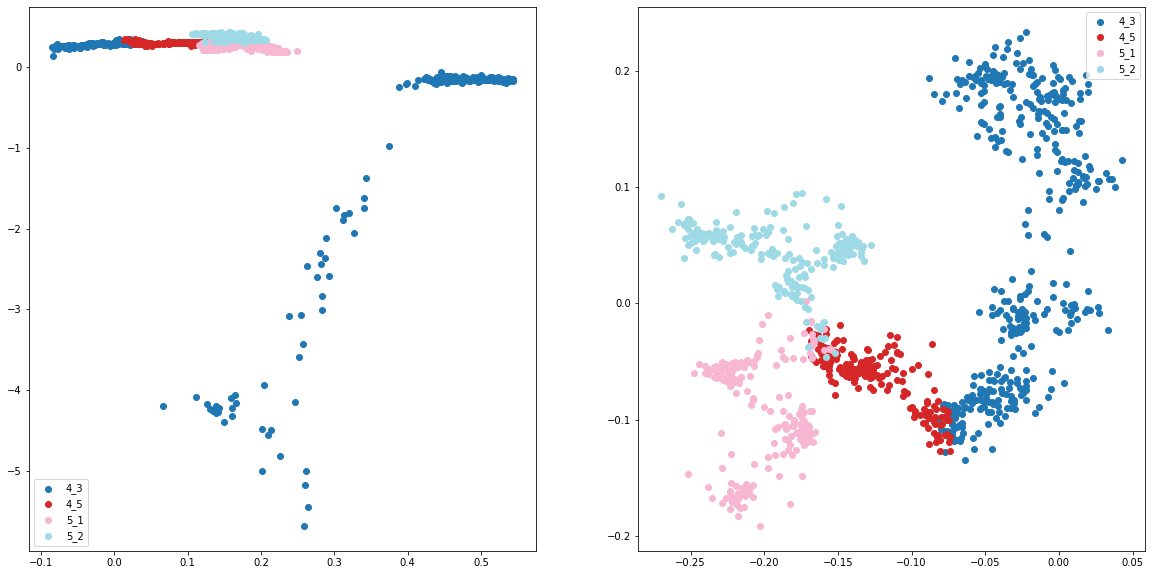

In [252]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels["pop"], anno2 = symsim_r1b2.cell_labels["pop"], mode = "separate",save = None)

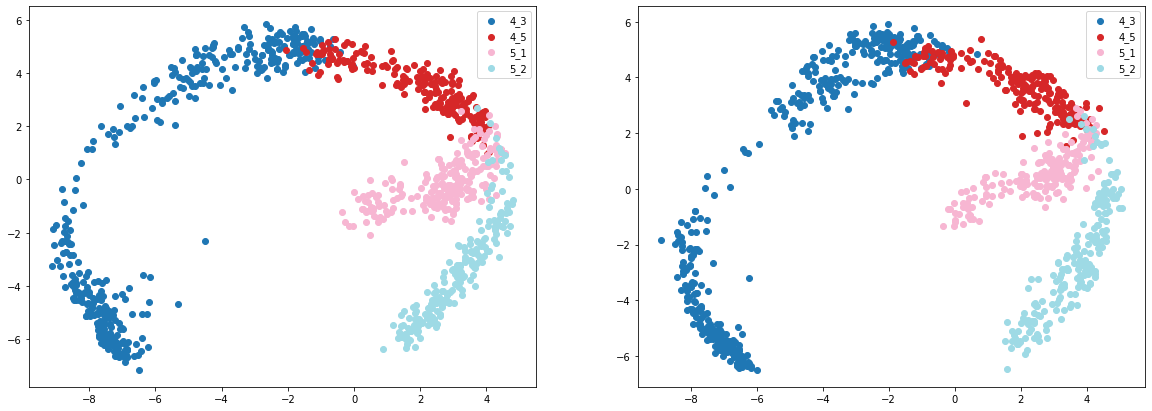

In [27]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1,2)

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[0].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)
axs[0].legend(cluster_types)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[1].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

axs[1].legend(cluster_types)

fig.savefig("./result/Symsim/phate_backbones_separate.pdf")

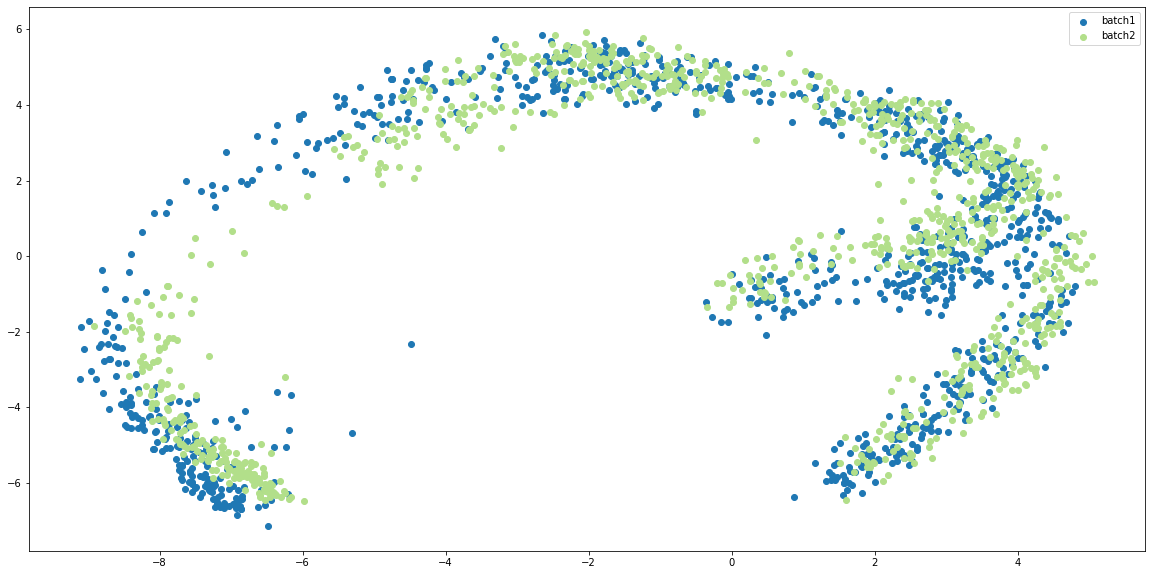

In [28]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
colormap = plt.cm.get_cmap("Paired")

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(1), label = "batch1", alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(2), label = "batch2", alpha = 1)

ax.legend()

fig.savefig("./result/Symsim/phate_batches_phate.pdf")